<a href="https://colab.research.google.com/github/ezekiel9m/ciencia_e_analise_de_dados/blob/main/base_Anomaly_Detction_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Atividade de Aprendizagem de Máquina
## Análise da base Unsupervised Anomaly Detection

Por Ezequiel Muxito

fonte - kaggle: https://github.com/Vicam/Unsupervised_Anomaly_Detection

In [ ]:
import warnings
warnings.filterwarnings("ignore")

from google.colab import drive
drive.mount('/content/drive')


In [ ]:
# Libraries
%matplotlib notebook

import pandas as pd
import numpy as np

import matplotlib
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

# Libraries for RNN
from tensorflow.keras.layers import Dense, Activation, Dropout, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# Return Series of distance between each point and distance with the closest centroid
def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.at[i] = np.linalg.norm(Xa-Xb)
    return distance

#### 1. Data
Dataset: https://www.kaggle.com/boltzmannbrain/nab
(ambient_temperature_system_failure.csv)

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/data_sets/ambient_temperature_system_failure.csv')

In [ ]:
data.head(5)

In [ ]:
print(data['timestamp'].head(10))

In [ ]:
df = data
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 2 columns):
timestamp    7267 non-null object
value        7267 non-null float64
dtypes: float64(1), object(1)
memory usage: 113.6+ KB
None


<IPython.core.display.Javascript object>


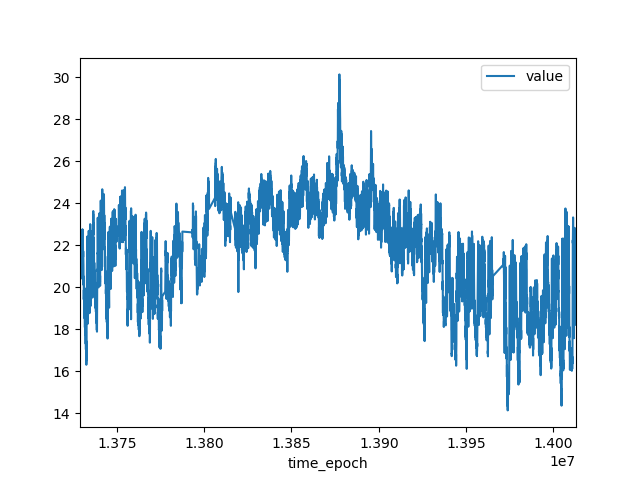

In [ ]:
outliers_fraction = 0.01
# Change timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])
# "Int" timestamp to plot easily
df['time_epoch'] = (df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)
# Change temperature to Celsius
df['value'] = (df['value'] - 32) * 5/9
# Plot the original data
df.plot(x='time_epoch', y='value')

#### 2. Models

##### 2.1 PCA

PCA (Principle Component Analysis) is used to reduce the dimension of datasets. After reduction, characteristics of the original data are retained to the greatest extent (measured by covariance). The principle of PCA is to map the original data into a new low-dimensional space by constructing a new feature space. PCA can improve the computing performance of data and alleviate "Curse of Dimensionality".

<IPython.core.display.Javascript object>


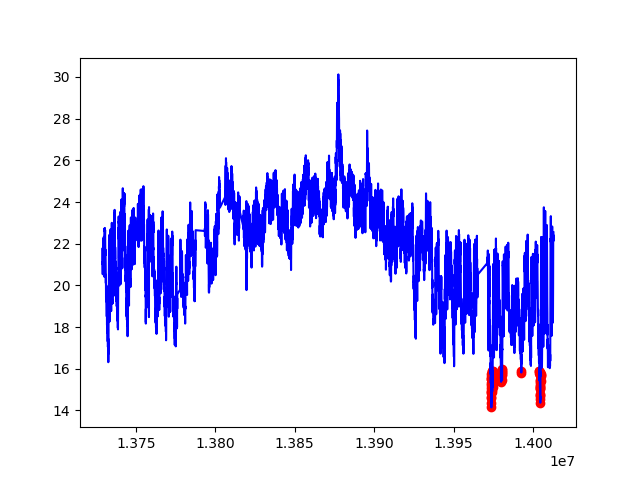

In [ ]:
# Take useful feature and standardize them
data = df[['value', 'time_epoch']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# Reduce to 2 importants features, default 'auto' is too large
pca = PCA(n_components=2)
data = pca.fit_transform(data)
# Standardize these 2 new features
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

# Calculate with different number of centroids to see the loss plot (elbow method)
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]

# Choose 15 centroids arbitrarily and add these data to the central dataframe
df['cluster'] = kmeans[14].predict(data)
df['principal_feature1'] = data[0]
df['principal_feature2'] = data[1]
df['cluster'].value_counts()

# Get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = getDistanceByPoint(data, kmeans[14])
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
df['anomaly'] = (distance >= threshold).astype(int)

# Plot
fig, ax = plt.subplots()
a = df.loc[df['anomaly'] == 1, ['time_epoch', 'value']]
ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

##### 2.2 Isolation Forest

Isolation Forest can be understood as an unsupervised random forest algorithm. The basic principle is to use a tree model to split the data until there is only one independent point. The faster it is divided into individual data points, the more abnormal the data is.

<IPython.core.display.Javascript object>


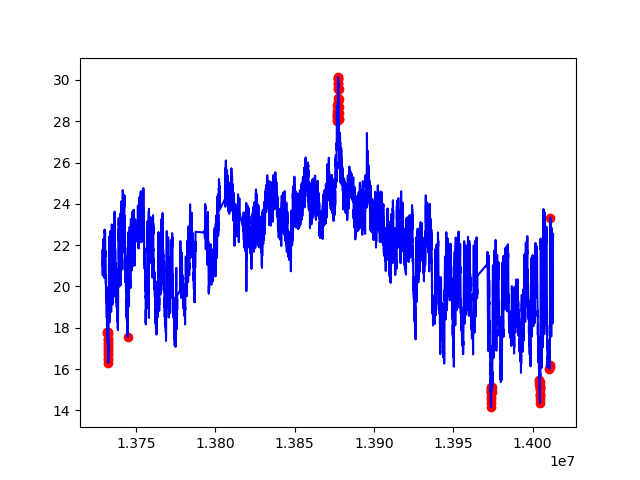

In [ ]:
# Take useful feature and standardize them
data = df[['value', 'time_epoch']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# Train isolation forest
model = IsolationForest(contamination = outliers_fraction)
model.fit(data)
df['anomaly'] = pd.Series(model.predict(data))
df['anomaly'] = df['anomaly'].map( {1: 0, -1: 1} )

# Plot
fig, ax = plt.subplots()

a = df.loc[df['anomaly'] == 1, ['time_epoch', 'value']]

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

##### 2.3 SVM

SVM (Support Vector Machine), a common classifier in supervised machine learning, is good for novelty detection (no anomalies in the train set).

<IPython.core.display.Javascript object>


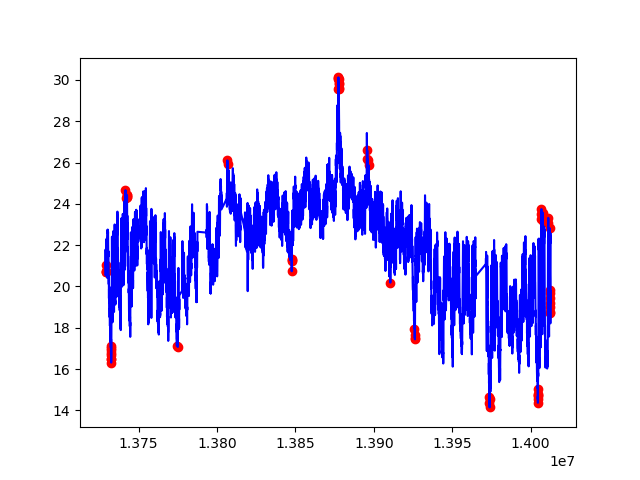

In [ ]:
# Take useful feature and standardize them
data = df[['value', 'time_epoch']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
# Train one class SVM
model = OneClassSVM(nu=0.95 * outliers_fraction)
data = pd.DataFrame(np_scaled)
model.fit(data)
df['anomaly'] = pd.Series(model.predict(data))
df['anomaly'] = df['anomaly'].map( {1: 0, -1: 1} )

# Plot
fig, ax = plt.subplots()

a = df.loc[df['anomaly'] == 1, ['time_epoch', 'value']]

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

##### 2.4 RNN

RNN (Recurrent Neural Networks) learn to recognize sequence in the data and then make prediction based on the previous sequence. We consider an anomaly when the next data points are distant from RNN prediction. Aggregation, size of sequence and size of prediction for anomaly are important parameters to have relevant detection.

In [ ]:
# Create sequence of 50 previous data points for each data points
def unroll(data,sequence_length=24):
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    return np.asarray(result)

In [ ]:
# Select and standardize data
data_n = df[['value', 'time_epoch']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data_n)
data_n = pd.DataFrame(np_scaled)

# Parameters and train/test size
prediction_time = 1
testdatasize = 1000
unroll_length = 50
testdatacut = testdatasize + unroll_length  + 1

# Train data
x_train = data_n[0:-prediction_time-testdatacut].as_matrix()
y_train = data_n[prediction_time:-testdatacut  ][0].as_matrix()

# Test data
x_test = data_n[0-testdatacut:-prediction_time].as_matrix()
y_test = data_n[prediction_time-testdatacut:  ][0].as_matrix()

# Adapt the datasets for the sequence data shape
x_train = unroll(x_train,unroll_length)
x_test  = unroll(x_test,unroll_length)
y_train = y_train[-x_train.shape[0]:]
y_test  = y_test[-x_test.shape[0]:]

# Shape it
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (6165, 50, 2)
y_train (6165,)
x_test (1000, 50, 2)
y_test (1000,)


In [ ]:
# Build the model
model = Sequential()
model.add(LSTM(
    128,
    input_dim=x_train.shape[-1],
    return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
    128,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print('compilation time : {}'.format(time.time() - start))

compilation time : 0.01293325424194336


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, None, 128)         67072     
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 198,785
Trainable params: 198,785
Non-trainable params: 0
________________________________________________

In [ ]:
# Train the model
es = EarlyStopping(monitor='val_loss', min_delta=0, mode='auto',patience=2, verbose=0)
model.fit(
    x_train,
    y_train,
    batch_size=2048,
    epochs=200,
    validation_split=0.1,
    callbacks=[es])

Train on 5548 samples, validate on 617 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/200
5548/5548 [==============================] - 8s 1ms/sample - loss: 0.5120 - val_loss: 0.8122
Epoch 2/200
5548/5548 [==============================] - 8s 1ms/sample - loss: 0.2389 - val_loss: 0.4476
Epoch 3/200
5548/5548 [==============================] - 11s 2ms/sample - loss: 0.1435 - val_loss: 0.3675
Epoch 4/200
5548/5548 [==============================] - 11s 2ms/sample - loss: 0.1424 - val_loss: 0.3797
Epoch 5/200
5548/5548 [==============================] - 10s 2ms/sample - loss: 0.1374 - val_loss: 0.3175
Epoch 6/200
5548/5548 [==============================] - 10s 2ms/sample - loss: 0.1308 - val_loss: 0.3102
Epoch 7/200
5548/5548 [==============================] - 9s 2ms/sample - loss: 0.1288 - val_loss: 0.2876
Epoch 8/200
5548/5548 [==============================] - 9s 2ms/sample - loss: 0.1258 - val_loss: 0.2939
Epoch 9/200
554

In [ ]:
# Create the list of difference between prediction and test data
diff=[]
ratio=[]
p = model.predict(x_test)

for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))

In [ ]:
# select the most distant prediction/reality data points as anomalies
diff = pd.Series(diff)
number_of_outliers = int(outliers_fraction*len(diff))
threshold = diff.nlargest(number_of_outliers).min()
# Anomaly
test = (diff >= threshold).astype(int)
# Normal
complement = pd.Series(0, index=np.arange(len(data_n)-testdatasize))
df['anomaly'] = complement.append(test, ignore_index='True')
print(df['anomaly'].value_counts())

0    7257
1      10
Name: anomaly, dtype: int64


<IPython.core.display.Javascript object>


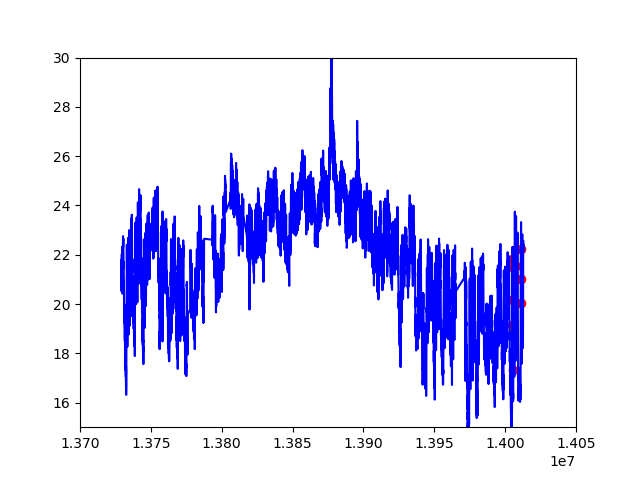

In [ ]:
# Plot
fig, ax = plt.subplots()

a = df.loc[df['anomaly'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.axis([1.370*1e7, 1.405*1e7, 15,30])
plt.show()

A partir do resultado acima, podemos ver que o iForest e o OC SVM funcionam bem para a avaliação comparativa de dados não ordenados.

Empiricamente, o método de agrupamento (PCA) e o iForest são bons para anomalias coletivas não ordenadas, as cadeias de Markov são boas para anomalias sequenciais ordenadas, o OC SVM é bom para detecção de novidades e o RNN é bom para detecção de anomalias contextuais.